In [124]:
%pylab inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams["font.size"] = "16"


import numpy as np
import matplotlib.pyplot as p
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter as gf
from astropy.coordinates import SkyOffsetFrame, ICRS, SkyCoord
from astropy import units as u
from astropy.visualization import ImageNormalize, MinMaxInterval, AsinhStretch
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs

In [162]:
import matplotlib
if (matplotlib.__version__ < '1.2'):
    from matplotlib.nxutils import points_inside_poly
else:
    from matplotlib.path import Path as mpl_path

def inside_poly(data, vertices):
    if(matplotlib.__version__ < '1.2'):
        return points_inside_poly(data, vertices)
    return mpl_path(vertices).contains_points(data)

In [125]:
imlist = ['jcb007fjq_drc.fits', 'jcb011v9q_drc.fits']
plist = ['/net/wien/data/users/balbinot/widebin/Fornax/E/east',
         '/net/wien/data/users/balbinot/widebin/Fornax/W/west']

out = np.array([])
imgref = 0

for imname, pname in zip(imlist, plist):

    img = fits.getdata(imname)

    x,y, sn, sharp, roundn, crow, t, v, ev, i, ei, V, eV, I, eI = np.loadtxt(pname,
                                                           usecols=(2,3,5,6,7,9,10,15,17,28,30,16,18,29,30), 
                                                           unpack=True)
    
    hdr = fits.getheader(imname, ext=1)
    w = WCS(hdr)
    ra, dec = w.all_pix2world(x,y,0)
    
    img = np.zeros_like(ra) + imgref
    print(imname, pname, imgref)
    imgref += 1
    
    try:
        out = np.r_[out, np.array([ra, dec, x, y, sn, sharp, roundn, crow, t, v, ev, i, ei, V, eV, I, eI, img]).T]
    except:
        out = np.array([ra, dec, x, y, sn, sharp, roundn, crow, t, v, ev, i, ei, V, eV, I, eI, img]).T
 
    print(out.shape)
    

jcb007fjq_drc.fits /net/wien/data/users/balbinot/widebin/Fornax/E/east 0
(245514, 18)
jcb011v9q_drc.fits /net/wien/data/users/balbinot/widebin/Fornax/W/west 1
(537524, 18)


In [126]:
ra     = out[:,0]
dec    = out[:,1]
xpx      = out[:,2]
ypx      = out[:,3]
sn     = out[:,4]
sharp  = out[:,5]
roundn = out[:,6]
crow   = out[:,7]
t      = out[:,8]
v      = out[:,9]
ev     = out[:,10]
i      = out[:,11]
ei     = out[:,12]
V      = out[:,13]
eV     = out[:,14]
I      = out[:,15]
eI     = out[:,16]
img    = out[:,17].astype(np.int)

In [127]:
blim = 17
flim = 26.5

# Envelope of sharpness
env = lambda mag: 0.07 + np.exp((mag - 28.5)/1.6)
img

array([0, 0, 0, ..., 1, 1, 1])

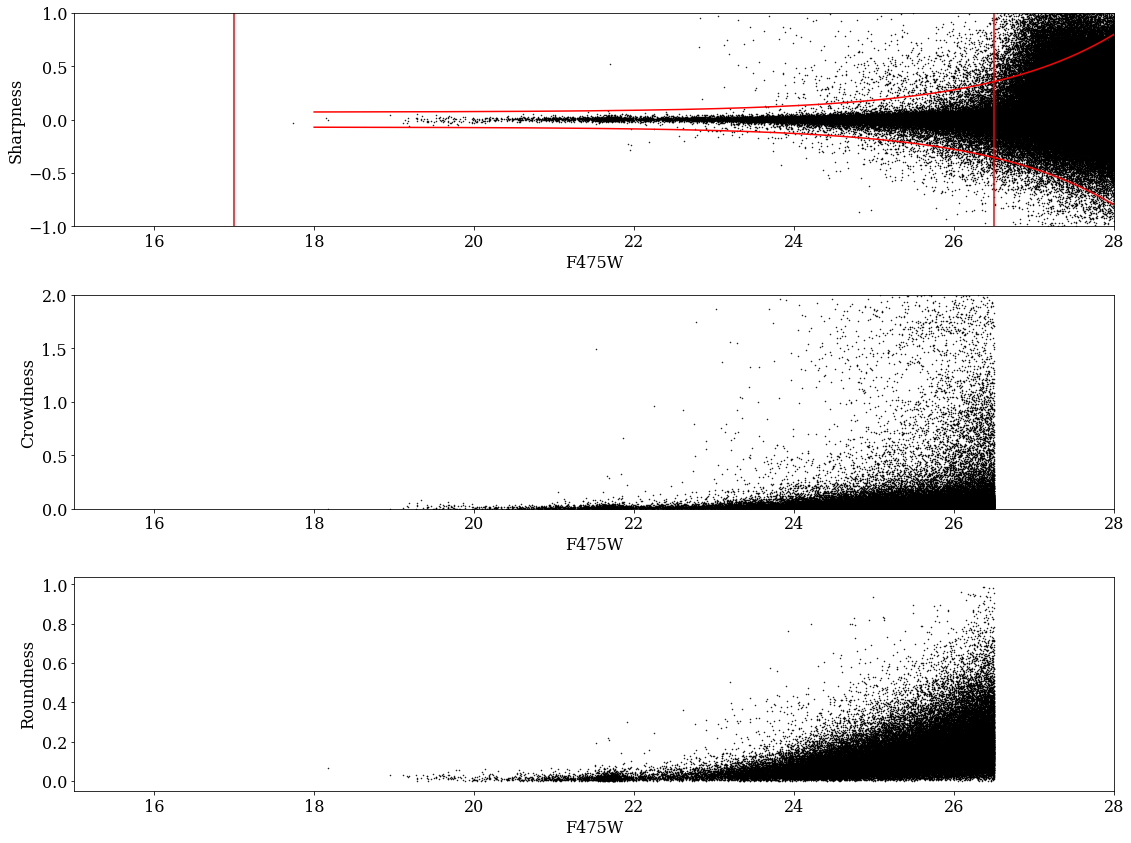

In [128]:
# Plot selection
figure(figsize=(16,12))

subplot(311)
plot(v, sharp, 'k.', ms=1)
X = np.arange(18,31,0.01)
plot(X, env(X),'r-')
plot(X, -env(X),'r-')
axvline(flim, c='r')
axvline(blim, c='r')
xlim(15,28)
ylim(-1,1)
xlabel('F475W')
ylabel('Sharpness')

j = (np.abs(sharp) - env(v) < 0)*(v < flim)*(v > blim)*(v < 80)*(i<80)*(roundn < 1)

subplot(312)
plot(v[j], crow[j], 'k.', ms=1)
xlim(15,28)
ylim(0,2)
xlabel('F475W')
ylabel('Crowdness')

subplot(313)
plot(v[j], roundn[j], 'k.', ms=1)
xlim(15,28)
xlabel('F475W')
ylabel('Roundness')
tight_layout()


Text(0,0.5,'F475W')

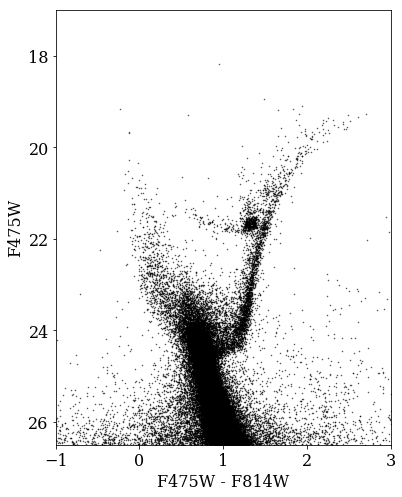

In [129]:
figure(figsize=(6,8))
plot(v[j]-i[j],v[j], 'k.', ms=1, alpha=0.7)
xlim(-1,3)
ylim(flim,blim)
xlabel('F475W - F814W')
ylabel('F475W')


In [98]:
## Get bright sources from the Gaia catalogue
censtr = "02h39m53s -34d30m25s"
cen = SkyCoord(censtr)
width = u.Quantity(30, u.arcmin)
height = u.Quantity(30, u.arcmin)
r = Gaia.query_object_async(coordinate=cen, width=width, height=height)
r.pprint()

Query finished.
         dist             solution_id     ... epoch_photometry_url
                                          ...                     
--------------------- ------------------- ... --------------------
0.0002157110064185294 1635721458409799680 ...                   --
0.0007147714993521153 1635721458409799680 ...                   --
 0.001046996936397457 1635721458409799680 ...                   --
0.0013342368035404453 1635721458409799680 ...                   --
0.0018040917411763688 1635721458409799680 ...                   --
 0.002241560590536903 1635721458409799680 ...                   --
 0.002483287237472329 1635721458409799680 ...                   --
 0.002836691576798055 1635721458409799680 ...                   --
0.0029511857376668424 1635721458409799680 ...                   --
 0.002951848141534566 1635721458409799680 ...                   --
                  ...                 ... ...                  ...
  0.31842293032278024 1635721458409799680 ... 

In [99]:
gRA = r['ra']
gDec = r['dec']
gG = r['phot_g_mean_mag']

gRA = gRA[gG < 19]
gDec = gDec[gG < 19]
gG = gG[gG < 19]

537524
[[-100 -160]
 [  -3  -62]
 [ -89   43]
 [-190  -55]]


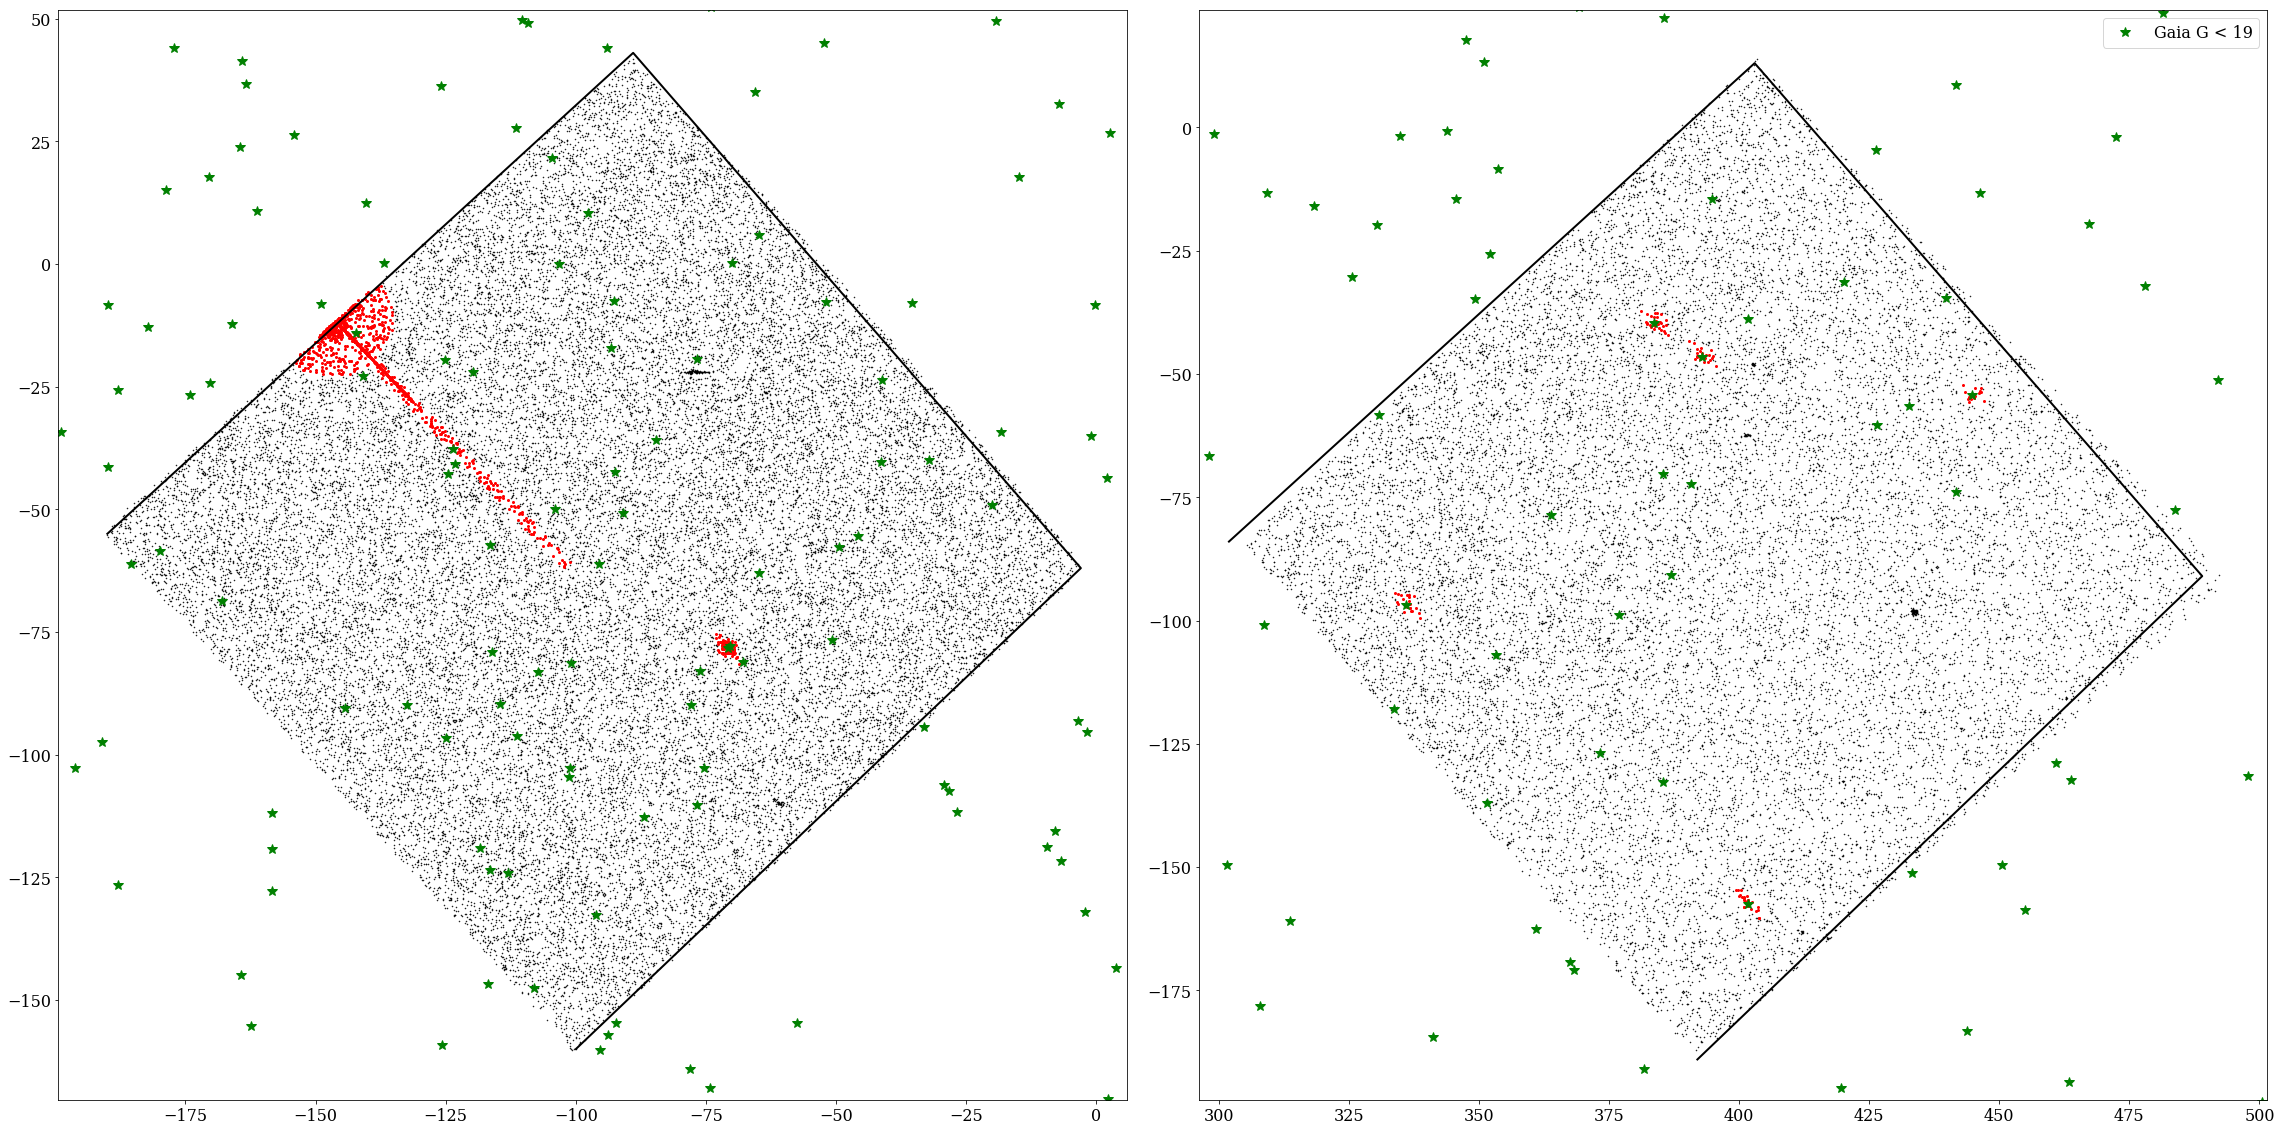

In [161]:

xc = cen.ra.deg
yc = cen.dec.deg

## Mask bad regions and brightstars 
## RA, Dec, radius[px], barlenght[px], barwidith[px]
bslist = [[1, 4187, 1927, 350, 2000, 30],
          [1, 1218, 2269, 60, 120, 20],
          [0, 2321, 429,  60, 120, 20],
          [0, 1129, 1413, 60, 120, 20],
          [0, 797, 1477 , 60, 120, 20],
          [0, 3737, 3409, 60, 120, 20],
          [0, 1109, 3653, 60, 120, 20],
         ]
    
bsmask = ra  < 0
for bs in bslist:
    R = np.sqrt((xpx - bs[1])**2 + (ypx - bs[2])**2)
    bsmask = bsmask|(img==bs[0])*((np.abs(ypx - bs[2]) < bs[5])*(np.abs(xpx - bs[1]) < bs[4]))|(R<bs[3])*(img==bs[0])

x = ra
y = dec
d = 140
X = 1000*d*np.cos(np.deg2rad(y))*np.sin(np.deg2rad(x - xc))
Y = 1000*d*(np.sin(np.deg2rad(y))*np.cos(np.deg2rad(yc)) - np.cos(np.deg2rad(y))*np.sin(np.deg2rad(yc))*np.cos(np.deg2rad(x - xc)))

Xg = 1000*d*np.cos(np.deg2rad(gDec))*np.sin(np.deg2rad(gRA - xc))
Yg = 1000*d*(np.sin(np.deg2rad(gDec))*np.cos(np.deg2rad(yc)) - np.cos(np.deg2rad(gDec))*np.sin(np.deg2rad(yc))*np.cos(np.deg2rad(gRA - xc)))

figure(figsize=(32,16))
ax1 = subplot(121)
plot(X[j*~bsmask*img==1], Y[j*~bsmask*img==1], 'k.', ms=1)
plot(X[j*bsmask*img==1], Y[j*bsmask*img==1], 'ro', ms=2)
autoscale(False)
plot(Xg, Yg, 'g*', ms=10, label='Gaia G < 19')

ax2 = subplot(122)
plot(X[j*~bsmask*(img==0)], Y[j*~bsmask*(img==0)], 'k.', ms=1)
plot(X[j*bsmask*(img==0)], Y[j*bsmask*(img==0)], 'ro', ms=2)
autoscale(False)
plot(Xg, Yg, 'g*', ms=10, label='Gaia G < 19')
legend(loc='best')

print(len(X))
tight_layout()

pol1 = np.array([[-100, -160],
               [-3, -62],
               [-89, 43],
               [-190, -55]])

pol0 = np.zeros_like(pol0)
pol0[:,0] = pol1[:,0] - np.mean(X[img==1]) + np.mean(X[img==0])
pol0[:,1] = pol1[:,1] - np.mean(Y[img==1]) + np.mean(Y[img==0])
print(pol1)


ax1.plot(pol1[:,0], pol1[:,1], 'k-', lw=2)
ax2.plot(pol0[:,0], pol0[:,1], 'k-', lw=2)
#np.savetxt('positions_HST_east.dat', np.array([X,Y]).T, fmt='%.5f')

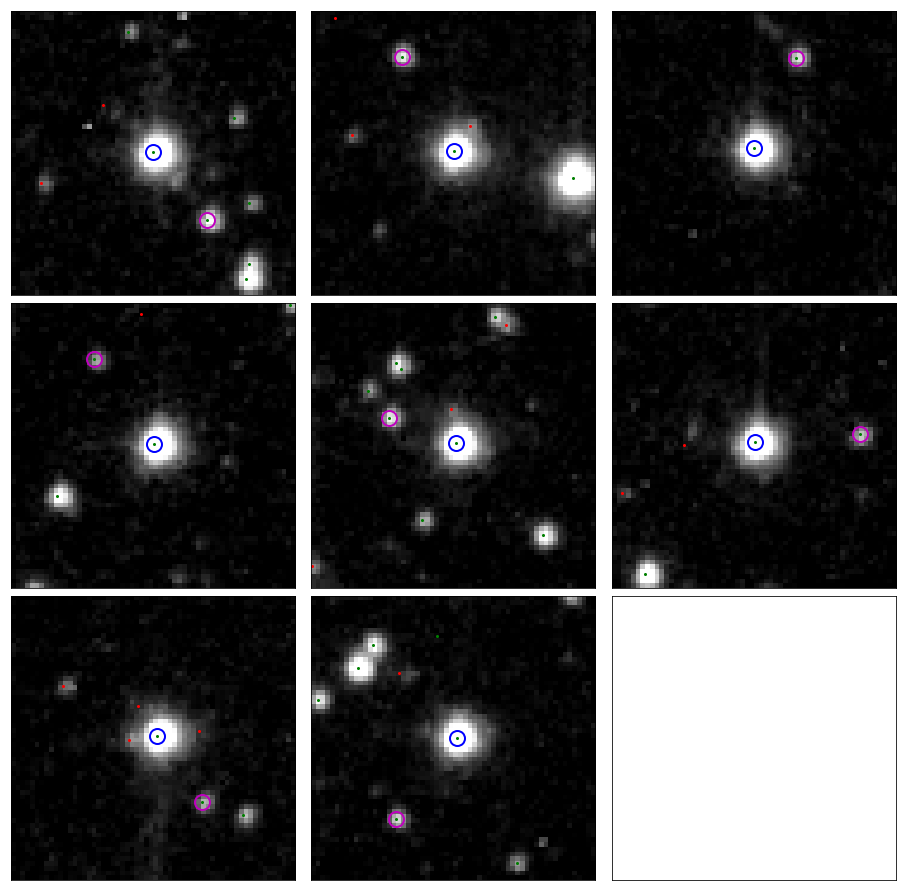

In [205]:
from sklearn.neighbors import NearestNeighbors

from matplotlib.colors import LogNorm, SymLogNorm

h = j*~bsmask
hi = np.where(h)[0]
POS = np.array([X[h], Y[h]]).T
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(POS)
distances, indices = nbrs.kneighbors(POS)
    
    
dcut = (distances[:,1]< 0.8)*(distances[:,1] > 0.5)
pidx= indices[dcut, 0]
cidx= indices[dcut, 1]


imgs = [fits.getdata('combined.fits', ext=0), fits.getdata(imlist[1], ext=1)]

fig, axs = plt.subplots(3, 3, figsize=(16, 16))
subplots_adjust(wspace=0.03, hspace=0.03)
    
    
ii = 20
n = 0
while n < len(axs.ravel()):
    
    prim = hi[pidx[ii]] # primary
    sec = hi[cidx[ii]]  # companion
    
    xx =  xpx[prim]
    yy =  ypx[prim]
    xx2 = xpx[sec]
    yy2 = ypx[sec]
    if xx > 3000 or xx < 1000 or yy > 3000 or yy < 1000:
        ii += 1
    else:
        
        ax = axs.ravel()[n]
        xmin, xmax = int(xx-30), int(xx+30)
        ymin, ymax = int(yy-30), int(yy+30)
        cutout = imgs[img[prim]][ymin:ymax, xmin:xmax]
        norm = ImageNormalize(cutout, vmin=0, vmax=300,
                      stretch=AsinhStretch())
        ax.imshow(cutout, cmap=cm.gray, extent=[xmin, xmax, ymin, ymax], origin='lower', norm=norm)
        
        ax.axes.get_yaxis().set_visible(False)
        ax.axes.get_xaxis().set_visible(False)
        autoscale(False)
        ax.plot(xx, yy, 'bo', ms=15, mew=2, mfc='None')
        ax.plot(xx2, yy2, 'mo', ms=15, mew=2, mfc='None')
        
        
        jj = (~j)*(img==img[prim])*(xpx < xmax)*(xpx > xmin)*(ypx < ymax)*(ypx > ymin)*(v < flim+0.5)
        ax.plot(xpx[jj], ypx[jj], 'r.', ms=4)
        jj = (j)*(img==img[prim])*(xpx < xmax)*(xpx > xmin)*(ypx < ymax)*(ypx > ymin)*(v < flim)
        ax.plot(xpx[jj], ypx[jj], 'g.', ms=4)
        ii +=1 
        n += 1
        
    

#figure(figsize=(16,8))
#plot(X[cidx], Y[cidx], 'k.', ms=1)
#gca().set_aspect('equal')




54751 53836


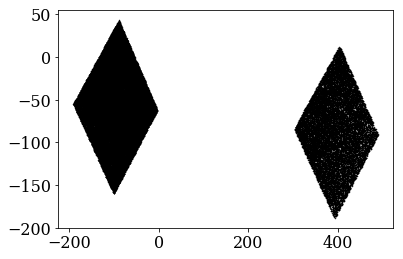

In [180]:
def sample_r(size=1):
    mu = np.random.random(size=size)
    return 1 / np.sqrt(mu**(-2/3) - 1)

n_samples = 2350000
r = sample_r(size=n_samples)

phi = np.random.uniform(0, 2*np.pi, size=n_samples)
theta = np.arccos(2*np.random.random(size=n_samples) - 1)

xyz = np.zeros((n_samples, 3))
xyz[:,0] = r * np.cos(phi) * np.sin(theta)
xyz[:,1] = r * np.sin(phi) * np.sin(theta)
xyz[:,2] = r * np.cos(theta)

pa = 46
PA = np.deg2rad(pa)
ecc=0.31
rs = np.deg2rad(12/60.)*140000

XYZ = np.zeros((n_samples, 2))
XYZ[:,0] = xyz[:,0]*rs/(1-ecc)
XYZ[:,1] = xyz[:,1]*rs

Xp = (XYZ[:,0]*np.cos(PA) - XYZ[:,1]*np.sin(PA))
Yp = (XYZ[:,0]*np.sin(PA) + XYZ[:,1]*np.cos(PA))

cut0 = inside_poly(np.array([Xp, Yp]).T, pol0)
cut1 = inside_poly(np.array([Xp, Yp]).T, pol1)

tt = cut0|cut1
              
print(len(Xp[tt]), len(X[j]))
plot(Xp[tt], Yp[tt], 'k.', ms=1)

                   
                   



In [191]:
from astroML.correlation import two_point
from astroML.decorators import pickle_results
from astroML.datasets import fetch_sdss_specgals
from astroML.correlation import bootstrap_two_point


data_real = np.array([X[j*~bsmask],Y[j*~bsmask]]).T
data_sim = np.array([Xp[tt],Yp[tt]]).T
data_sim = np.array([Xp[:3*54751],Yp[:3*54751]]).T

#@pickle_results("correlation_functions.pkl")
def compute_results(Nbins=10, Nbootstraps=10,  method='standard', rseed=0):
    np.random.seed(rseed)
    #bins = 10 ** np.linspace(np.log10(1. / 100.), np.log10(100), Nbins)
    bins = np.array([0, 0.5, 1, 10, 20, 30, 100])
    bins = 10**np.linspace(np.log10(0.05), np.log10(20), 30)
    results = [bins]
    for D in [data_real, data_sim]:
        results += bootstrap_two_point(D,
                                       bins=bins,
                                       method=method,
                                       Nbootstrap=Nbootstraps,
                                       return_bootstraps=True)

    return results

In [192]:
(bins, real_corr, real_corr_err, real_bootstraps, sim_corr, sim_corr_err, sim_bootstraps) = compute_results()
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Plot the results
corr = [real_corr, sim_corr]
corr_err = [real_corr_err, sim_corr_err]
bootstraps = [real_bootstraps, sim_bootstraps]


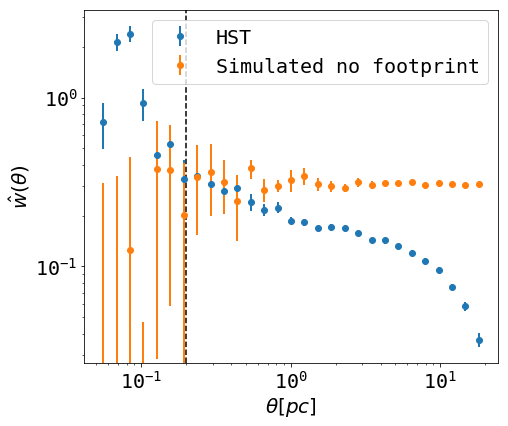

In [194]:
rcParams['font.family'] = 'monospace'
rcParams["font.size"] = "20"

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)
ax = subplot(111)
loglog()

labels = ['HST', 'Simulated no footprint']

for hh in range(2):

    ax.errorbar(bin_centers, corr[hh], corr_err[hh],
            fmt='o', lw=2, label=labels[hh])

ax.set_ylabel(r'$\hat{w}(\theta)$')
ax.set_xlabel(r'$\theta [pc]$')
ax.legend(loc='best')
axvline(0.2, ls='--', c='k')
